In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR

import datetime

In [2]:
vegas_df = pd.read_csv('LasVegasTripAdvisorReviews-Dataset.csv', delimiter=';', decimal=',')
vegas_df.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3.0,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3.0,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3.0,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3.0,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3.0,3773,North America,7,March,Tuesday


In [3]:
# def DurationOfStay(dataframe):
#     data = dataframe.copy()
#     # vegas_prep = vegas_df.copy()
#     data['Stay Started'] = data['Period of stay'].str.partition('-')[0]
#     data['Stay Ended'] = data['Period of stay'].str.partition('-')[2]
#     data['Duration of Stay'] = ""

#     for i, r in data.iterrows():
    
#         data['Stay Started'][i] = datetime.datetime.strptime(r['Stay Started'], '%b').month
#         data['Stay Ended'][i] = datetime.datetime.strptime(r['Stay Ended'], '%b').month

#         if data['Stay Started'][i] < data['Stay Ended'][i]:
#             data['Duration of Stay'][i] = np.abs(data['Stay Started'][i] - data['Stay Ended'][i]) + 1
#         else:
#             data['Duration of Stay'][i] = np.abs(data['Stay Started'][i] - (data['Stay Ended'][i] + 12)) + 1

#     return data

# vegas_prep = DurationOfStay(vegas_df)
# vegas_prep.head()


In [4]:
vegas_df['User continent'].value_counts()

North America    295
Europe           118
Oceania           41
Asia              36
Africa             7
South America      7
Name: User continent, dtype: int64

array([[<AxesSubplot:title={'center':'Nr. reviews'}>,
        <AxesSubplot:title={'center':'Nr. hotel reviews'}>,
        <AxesSubplot:title={'center':'Helpful votes'}>],
       [<AxesSubplot:title={'center':'Score'}>,
        <AxesSubplot:title={'center':'Hotel stars'}>,
        <AxesSubplot:title={'center':'Nr. rooms'}>],
       [<AxesSubplot:title={'center':'Member years'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

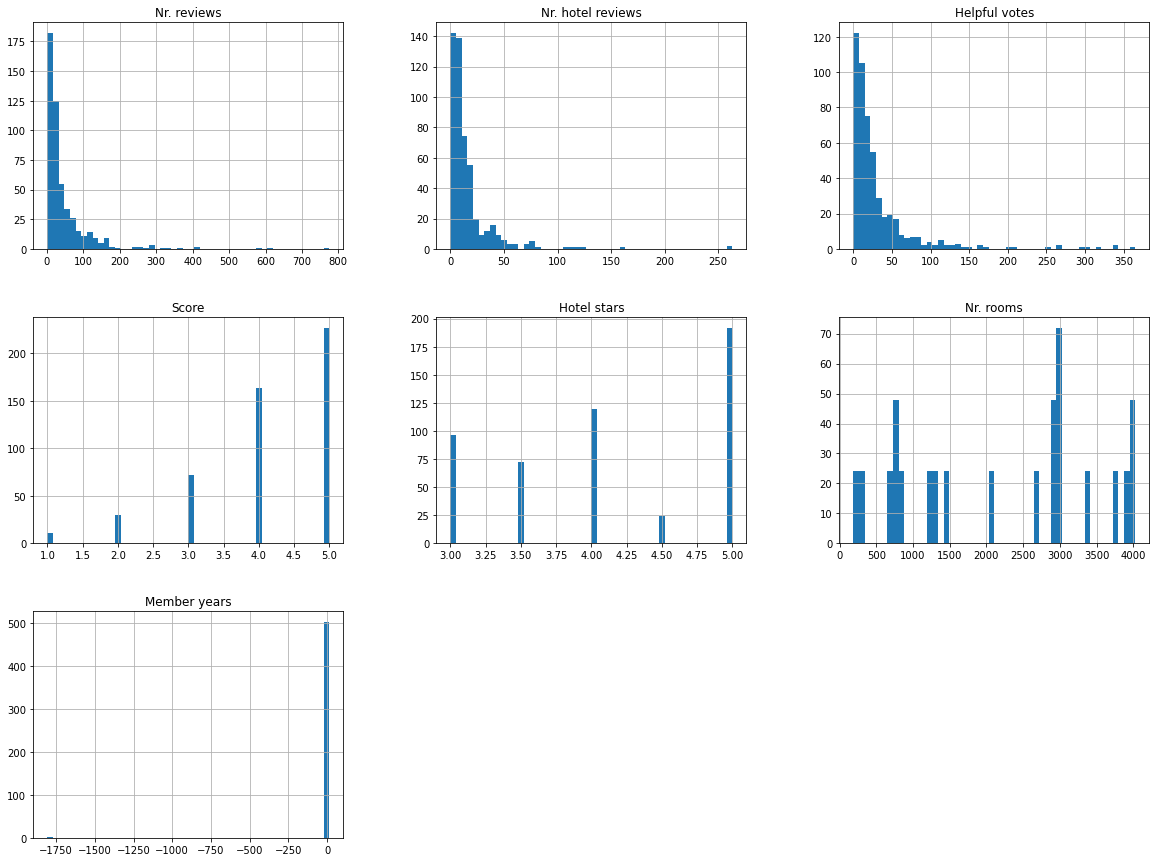

In [5]:
vegas_df.hist(bins=50, figsize=(20,15))

In [6]:
train_set, test_set = train_test_split(vegas_df, test_size=0.2, random_state=69)

In [7]:
corr_matrix = vegas_df.corr()
corr_matrix['Score'].sort_values()

Nr. rooms           -0.080200
Member years        -0.036190
Nr. reviews         -0.024320
Nr. hotel reviews    0.013718
Helpful votes        0.015472
Hotel stars          0.191490
Score                1.000000
Name: Score, dtype: float64

In [8]:
vegas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   User country       504 non-null    object 
 1   Nr. reviews        504 non-null    int64  
 2   Nr. hotel reviews  504 non-null    int64  
 3   Helpful votes      504 non-null    int64  
 4   Score              504 non-null    int64  
 5   Period of stay     504 non-null    object 
 6   Traveler type      504 non-null    object 
 7   Pool               504 non-null    object 
 8   Gym                504 non-null    object 
 9   Tennis court       504 non-null    object 
 10  Spa                504 non-null    object 
 11  Casino             504 non-null    object 
 12  Free internet      504 non-null    object 
 13  Hotel name         504 non-null    object 
 14  Hotel stars        504 non-null    float64
 15  Nr. rooms          504 non-null    int64  
 16  User continent     504 non

In [9]:
vegas_df.columns

Index(['User country', 'Nr. reviews', 'Nr. hotel reviews', 'Helpful votes',
       'Score', 'Period of stay', 'Traveler type', 'Pool', 'Gym',
       'Tennis court', 'Spa', 'Casino', 'Free internet', 'Hotel name',
       'Hotel stars', 'Nr. rooms', 'User continent', 'Member years',
       'Review month', 'Review weekday'],
      dtype='object')

In [10]:
vegas_num = train_set[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Hotel stars', 'Nr. rooms', 'Member years']]
num_attribs = ['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Hotel stars', 'Nr. rooms', 'Member years']
vegas_cat = train_set[['Traveler type', 'Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet', 'User continent']]
cat_attribs = ['Traveler type', 'Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet']
label_set = train_set['Score']

ordinal_encoder = OrdinalEncoder()
vegas_cat_encoded = ordinal_encoder.fit_transform(vegas_cat)
vegas_cat_encoded[:10]

array([[3., 1., 1., 0., 1., 1., 1., 2.],
       [2., 1., 1., 0., 0., 0., 1., 3.],
       [0., 1., 1., 0., 1., 1., 1., 2.],
       [3., 1., 1., 0., 0., 0., 1., 3.],
       [1., 1., 1., 0., 1., 1., 1., 3.],
       [2., 0., 1., 0., 0., 1., 1., 3.],
       [0., 1., 1., 0., 0., 0., 1., 3.],
       [0., 1., 1., 1., 1., 1., 1., 3.],
       [0., 1., 1., 0., 0., 1., 1., 3.],
       [3., 0., 1., 0., 0., 1., 1., 4.]])

In [11]:
class  CatTransform(BaseEstimator, TransformerMixin):    
    def __init__(self):
        return print('kuki')

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        data = X.copy()
        # vegas_prep = vegas_df.copy()
        data['Stay Started'] = data['Period of stay'].str.partition('-')[0]
        data['Stay Ended'] = data['Period of stay'].str.partition('-')[2]
        data['Duration of Stay'] = ""
        data.drop(['Period of stay'], axis=1, inplace=True)

        for i, r in data.iterrows():
        # r['Stay Started'][i] = datetime.datetime.strptime(vegas_df['Stay Started'][i], '%b').month
            data['Stay Started'][i] = datetime.datetime.strptime(r['Stay Started'], '%b').month
            data['Stay Ended'][i] = datetime.datetime.strptime(r['Stay Ended'], '%b').month

            if data['Stay Started'][i] < data['Stay Ended'][i]:
                data['Duration of Stay'][i] = np.abs(data['Stay Started'][i] - data['Stay Ended'][i]) + 1
            else:
                data['Duration of Stay'][i] = np.abs(data['Stay Started'][i] - (data['Stay Ended'][i] + 12)) + 1

            if data['User continent'][i] != 'North America':
                data['User continent'][i] = 0

            else:
                data['User continent'][i] = 1

        return data




In [12]:
pipe = Pipeline([
    ('test', CatTransform()),
    
])

segg = pipe.fit_transform(train_set)

kuki


In [13]:
pipline_imputer = ColumnTransformer([
    ('nums', SimpleImputer(), num_attribs),
    ('new_cols', CatTransform(), ['Period of stay', 'User continent'] ),
    ('cat_encoding', OrdinalEncoder(), cat_attribs)
])

vegas_imputer = pipline_imputer.fit_transform(train_set)

pipline_scaled = ColumnTransformer([
    ('nums', MinMaxScaler(), num_attribs),
    ('new_cols', CatTransform(), ['Period of stay', 'User continent'] ),
    ('cat_encoding', OrdinalEncoder(), cat_attribs)
])

vegas_scaled = pipline_scaled.fit_transform(train_set)

kuki
kuki
kuki
kuki


1

In [14]:
param_svr = [
    {'kernel':['linear'], 'C': [2, 20, 50]},
    {'kernel': ['rbf'], 'C':[3, 30, 90], 'gamma':[0.01, 0.1, 1, 10]}
]

# vegas_scaled_test = vegas_scaled[:300]
# vegas_imputer_test = vegas_imputer[:300]
# label_set = label_set[:300]


In [15]:
svm_reg = SVR()

In [16]:


# grid_search_imputer = GridSearchCV(svm_reg, param_svr, cv=3, scoring='neg_mean_squared_error', verbose=2)
# grid_search_imputer.fit(vegas_imputer_test, label_set )
# print(grid_search_imputer.best_params_, grid_search_imputer.best_estimator_)

In [23]:
grid_search_scaled = GridSearchCV(svm_reg, param_svr, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search_scaled.fit(vegas_scaled, label_set )
print(grid_search_scaled.best_params_, grid_search_scaled.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END ................................C=20, kernel=linear; total time=   0.0s
[CV] END ................................C=20, kernel=linear; total time=   0.1s
[CV] END ................................C=20, kernel=linear; total time=   0.0s
[CV] END ................................C=20, kernel=linear; total time=   0.0s
[CV] END ................................C=20, kernel=linear; total time=   0.0s
[CV] END ................................C=50, kernel=linear; total time=   0.2s
[CV] END ................................C=50, k

In [24]:
pipline_scaled_standard = ColumnTransformer([
    ('nums', StandardScaler(), num_attribs),
    ('new_cols', CatTransform(), ['Period of stay', 'User continent'] ),
    ('cat_encoding', OrdinalEncoder(), cat_attribs)
])

vegas_scaled_standard = pipline_scaled_standard.fit_transform(train_set)

grid_search_scaled_standard = GridSearchCV(svm_reg, param_svr, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search_scaled_standard.fit(vegas_scaled_standard, label_set )
print(grid_search_scaled_standard.best_params_, grid_search_scaled_standard.best_estimator_)

kuki
kuki
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END .................................C=2, kernel=linear; total time=   0.0s
[CV] END ................................C=20, kernel=linear; total time=   0.1s
[CV] END ................................C=20, kernel=linear; total time=   0.1s
[CV] END ................................C=20, kernel=linear; total time=   0.0s
[CV] END ................................C=20, kernel=linear; total time=   0.0s
[CV] END ................................C=20, kernel=linear; total time=   0.1s
[CV] END ................................C=50, kernel=linear; total time=   0.3s
[CV] END .............................

array([[<AxesSubplot:title={'center':'Nr. reviews'}>,
        <AxesSubplot:title={'center':'Nr. hotel reviews'}>,
        <AxesSubplot:title={'center':'Helpful votes'}>],
       [<AxesSubplot:title={'center':'Score'}>,
        <AxesSubplot:title={'center':'Hotel stars'}>,
        <AxesSubplot:title={'center':'Nr. rooms'}>],
       [<AxesSubplot:title={'center':'Member years'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

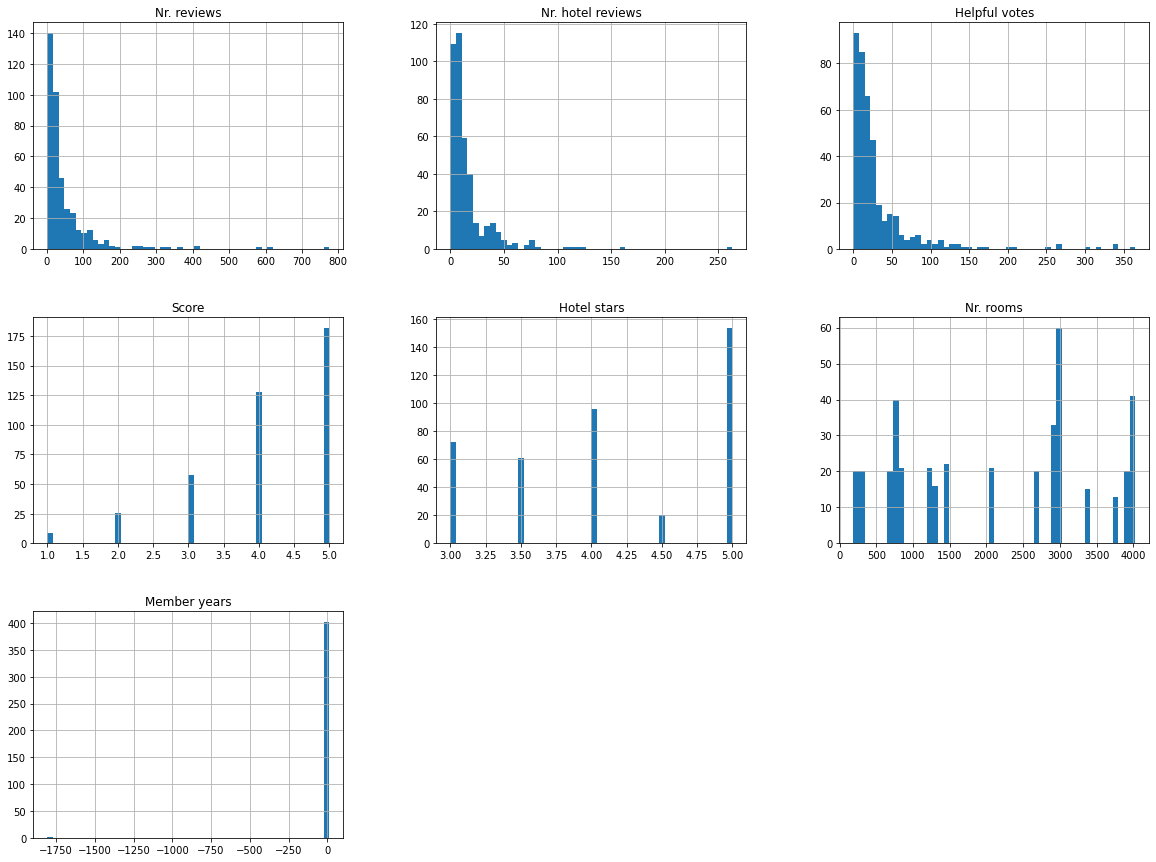

In [25]:

train_set.hist(bins=50, figsize=(20,15))

In [26]:
scaled_rmse = np.sqrt(-grid_search_scaled.best_score_)
standard_rmse = np.sqrt(-grid_search_scaled_standard.best_score_)

print(scaled_rmse, standard_rmse)

1.037879420539884 1.0463824298361282


2

In [33]:
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_svr, cv=8, n_iter=10, scoring='neg_mean_squared_error', random_state=69)
rnd_search.fit(vegas_scaled, label_set)
print(np.sqrt(-rnd_search.best_score_))

1.0333365322074646


4

In [39]:
pipline_full = Pipeline([
    ('prep', pipline_scaled),
    # ('svm', SVR(** rnd_search.best_params_))
])

pipline_full.fit(vegas_scaled)


ValueError: Specifying the columns using strings is only supported for pandas DataFrames